In [3]:
from collections import OrderedDict
from noaa_coops import Station
from deepdiff import DeepDiff
import datetime as dt
import pandas as pd
import numpy as np
import calendar
import os
import json
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [4]:
# import matplotlib.ticker as ticker
# import matplotlib.dates as mdates

***

In [63]:
class Data:
    def __init__(self, stationname, stationid, units='metric', timezone='gmt', datum='MHHW',
                 outdir=None, hr_threshold=3, day_threshold=2, redownload=False, verbose=True):
        """Data class for downloading, formatting, and saving to file historical
        atmospheric (air temperature, barometric pressure, wind) and oceanographic
        (water temperature, water level) data from NOAA CO-OPS coastal tide stations.
        WARNING: This may take a while to initiate depending on the amount of data
        to be retrieved.
        
        Inputs:
            stationname: str, desired name of station. Does not need to be the CO-OPS
                name; it is used only for saving data to file.
            stationid: str, NOAA CO-OPS tide station number from which to retrieve data
            outdir: str, directory to save data to. Defaults to present working directory.
            units: str, either 'metric' or 'english', indicating the units to download
                data in. Defaults to 'metric'.
            timezone: str, one of either 'gmt' for Greenwich Mean Time, 'lst' for local
                standard time, or 'lst_ldt' for adjusted local standard/daylight savings
                time. Defaults to 'gmt'.
            datum: str, tidal datum for water level data. Options: 'STND', 'MHHW', 'MHW',
                'MTL', 'MSL', 'MLW', 'MLLW', 'NAVD' Defaults to 'MHHW'.
            hr_threshold: int, maximum number of hours of data that can be missing in a
                given day in order for that day to be included in the historical record.
                Default is 3.
            day_threshold: int, maximum number of days of data that can be missing in a
                given month in order for that month to be included in the historical record.
                Default is 2.
            redownload: Bool, if True, historical data will be redownloaded and the class
                instance will be re-initiated. Defaults to False.
            verbose: Bool, print statuses to screen. Defaults to True.
        """
        
        self.name = stationname
        self.dirname = self._camel(stationname)
        self.id = stationid
        self.unit_system = units.lower()
        self.tz = timezone.lower()
        self.datum = datum.upper()
        self.hr_threshold = hr_threshold
        self.day_threshold = day_threshold
        self.verbose = verbose
        self.variables = []
        today = self._format_date(pd.to_datetime('today'))
        
        # Check for valid arguments
        self._valid_units(self.unit_system)
        self._valid_tz(self.tz)
        self._valid_datum(self.datum)
        
        # Set data directory, creating station subdirectory if needed
        if outdir:
            self.outdir = os.path.join(outdir, self.dirname)
        else:
            self.outdir = os.path.join(os.getcwd(), self.dirname)

        # ============================================================
        # If 'redownload' argument is True OR if the directory station
        # name subdirectory does not exist within 'outdir', then create
        # that subdirectory and download historical data.
        if not os.path.exists(self.outdir) or redownload:
            if not os.path.exists(self.outdir):
                if self.verbose:
                    print('Creating new directory for this station.')
                os.makedirs(self.outdir)
        
            # Download all data and save to file
            self.download_data(start_date=None, end_date=None)
            # self.download_data(start_date=self._format_date('2023-01-01'), end_date=self._format_date('2023-10-01'))
            self.filtered_data = {var: self._filter_data(self.data[var],
                                                         hr_threshold=self.hr_threshold,
                                                         day_threshold=self.day_threshold) \
                                  for var in self.variables}
            self.filtered_data.to_csv(os.path.join(self.outdir, 'observational_data_record.csv.gz'),
                             compression='infer')
            if self.verbose:
                print("Observational data written to file "\
                      f"'{os.path.join(self.outdir, 'observational_data_record.csv')}'.")

            # Store units
            self.unit_options = dict({
                'Air Temperature': {'metric': 'C', 'english': 'F'},
                'Barometric Pressure': {'metric': 'mb', 'english': 'mb'},
                'Wind Speed': {'metric': 'm/s', 'english': 'kn'},
                'Wind Gust': {'metric': 'm/s', 'english': 'kn'},
                'Wind Direction': {'metric': 'deg', 'english': 'deg'},
                'Water Temperature': {'metric': 'C', 'english': 'F'},
                'Water Level': {'metric': 'm', 'english': 'ft'}
            })
            self.units =  {k:v[self.unit_system] for k,v in self.unit_options.items() if k in self.variables}
            
            # Save class variables
            meta = dict({
                'stationname': self.name,
                'stationid': self.id,
                'outdir': self.outdir,
                'unit_system': self.unit_system,
                'tz': self.tz,
                'datum': self.datum,
                'hr_threshold': self.hr_threshold,
                'day_threshold': self.day_threshold,
                'variables': self.variables,
                'units': self.units})
            with open(os.path.join(self.outdir, 'metadata.json'), 'w') as fp:
                json.dump(meta, fp) 
                    
            # Create and save statistics dictionaries
            # Daily stats
            self.daily_stats_dict = self.daily_stats()
            statsOutFile = os.path.join(self.outdir, 'statistics-daily.json')
            with open(statsOutFile, 'w') as fp:
                json.dump(self.daily_stats_dict, fp)
            if self.verbose:
                print(f"Observational daily statistics written to '{statsOutFile}'")
            # Monthly stats
            self.monthly_stats_dict = self.monthly_stats()
            statsOutFile = os.path.join(self.outdir, 'statistics-monthly.json')
            with open(statsOutFile, 'w') as fp:
                json.dump(self.monthly_stats_dict, fp)
            if self.verbose:
                print(f"Observational monthly statistics written to '{statsOutFile}'")            

        # ===================================================    
        # If historical data for this station already exists:
        else:
            # Load the metadata from file
            if self.verbose:
                print('Loading metadata from file')
            with open(os.path.join(self.outdir, 'metadata.json')) as m:
                meta = json.load(m)
            self._load_from_json(meta)
            
            # Load the historical data from file
            if self.verbose:
                print('Loading historical data from file')
            self.data = pd.read_csv(os.path.join(self.outdir, 'observational_data_record.csv.gz'),
                                    index_col=f'time_{self.tz}', parse_dates=True,
                                    compression='infer')
            
            # Load daily statistics from file
            if self.verbose:
                print('Loading daily statistics from file')
            with open(os.path.join(self.outdir, 'statistics-daily.json')) as s:
                self.daily_stats_dict = json.load(s)
            self.daily_stats_tables = self.stats_table(self.daily_stats_dict)

            # Load monthly statistics from file
            if self.verbose:
                print('Loading monthly statistics from file')
            with open(os.path.join(self.outdir, 'statistics-monthly.json')) as s:
                self.monthly_stats_dict = json.load(s)
            self.monthly_stats_tables = self.stats_table(self.monthly_stats_dict)

            # Clean and format
            if self.verbose:
                print('Filtering data')
            self.filtered_data = {var: self._filter_data(self.data[var],
                                                         hr_threshold=self.hr_threshold,
                                                         day_threshold=self.day_threshold) \
                                  for var in self.variables}                
        if self.verbose:
            print('Done!')
        
    def download_data(self, start_date=None, end_date=None):
        """Download data from NOAA CO-OPS"""
        if self.verbose:
            print('Downloading historic data')
        
        # NOAA CO-OPS API
        self.station = Station(id=self.id)

        # List of data variables to combine at the end
        datasets = []

        # If no 'end_date' is passed, download through current day
        if not end_date:
            end_date = self._format_date(pd.to_datetime('today'))

        # Air temperature
        if 'Air Temperature' in self.station.data_inventory:
            self.variables.append('Air Temperature')
            if not start_date:
                start_date = self._format_date(self.station.data_inventory['Air Temperature']['start_date'])
            self._load_atemp(start_date=start_date, end_date=end_date)
            self.air_temp['atemp_flag'] = self.air_temp['atemp_flag'].str.split(',', expand=True).astype(int).sum(axis=1)
            self.air_temp.loc[self.air_temp['atemp_flag'] > 0, 'atemp'] = np.nan
            datasets.append(self.air_temp['atemp'])

        # # Barometric pressure
        # if 'Barometric Pressure' in self.station.data_inventory:
        #     self.variables.append('Barometric Pressure')
        #     if not start_date:
        #         start_date = self._format_date(self.station.data_inventory['Barometric Pressure']['start_date'])
        #     self._load_atm_pres(start_date=start_date, end_date=end_date)
            # self.pressure['apres_flag'] = self.pressure['apres_flag'].str.split(',', expand=True).astype(int).sum(axis=1)
            # self.pressure.loc[self.pressure['apres_flag'] > 0, 'apres'] = np.nan
        #     datasets.append(self.pressure['apres'])

        # # Wind
        # if 'Wind' in self.station.data_inventory:
        #     self.variables.extend(['Wind Speed', 'Wind Gust'])
        #     if not start_date:
        #         start_date = self._format_date(self.station.data_inventory['Wind']['start_date'])
        #     self._load_wind(start_date=start_date, end_date=end_date)
            # self.wind['windflag'] = self.wind['wind_flag'].str.split(',', expand=True).astype(int).sum(axis=1)
            # self.wind.loc[self.wind['wind_flag'] > 0, ['windspeed', 'windgust']] = np.nan
        #     datasets.append(self.wind[['windspeed', 'windgust']])

        # Water temperature
        if 'Water Temperature' in self.station.data_inventory:
            self.variables.append('Water Temperature')
            if not start_date:
                start_date = self._format_date(self.station.data_inventory['Water Temperature']['start_date'])
            self._load_water_temp(start_date=start_date, end_date=end_date)
            self.water_temp['wtemp_flag'] = self.water_temp['wtemp_flag'].str.split(',', expand=True).astype(int).sum(axis=1)
            self.water_temp.loc[self.water_temp['wtemp_flag'] > 0, 'wtemp'] = np.nan
            datasets.append(self.water_temp['wtemp'])

        # # Water level (tides)
        # if 'Verified 6-Minute Water Level' in self.station.data_inventory:
        #     self.variables.append('Water Level')
        #     if not start_date:
        #         start_date = self._format_date(self.station.data_inventory['Verified 6-Minute Water Level']['start_date'])
        #     self._load_water_level(start_date=start_date, end_date=end_date)
            # self.water_levels['wlevel_flag'] = self.water_levels['wlevel_flag'].str.split(',', expand=True).astype(int).sum(axis=1)
            # self.water_levels.loc[self.water_levels['wlevel_flag'] > 0, 'wlevel'] = np.nan
        #     datasets.append(self.water_levels['wlevel'])

        # Merge into single dataframe
        if self.verbose:
            print('Compiling data')
        self.data = pd.concat(datasets, axis=1)
        self.data.index.name = f'time_{self.tz}'
        self.data.columns = [i for i in self.variables]

    def update_data(self, start_date=None, end_date=None):
        """Download data from NOAA CO-OPS"""
        if self.verbose:
            print('Downloading latest data')

        # NOAA CO-OPS API
        self.station = Station(id=self.id)

        # List of data variables to combine at the end
        datasets = []
        
        # If no 'start_date' is passed, pick up from the last observation time
        if not start_date:
            start_date = self._format_date(self.data.index.max())
            
        # If no 'end_date' is passed, download through end of current date
        if not end_date:
            end_date = self._format_date(pd.to_datetime('today') + pd.Timedelta(days=1))
        
        # Air temperature
        if 'Air Temperature' in self.variables:
            self._load_atemp(start_date=start_date, end_date=end_date)
            datasets.append(self.air_temp['atemp'])

        # Barometric pressure
        if 'Barometric Pressure' in self.variables:
            self._load_atm_pres(start_date=start_date, end_date=end_date)
            datasets.append(self.pressure['apres'])

        # Wind
        if 'Wind Speed' in self.variables:
            self._load_wind(start_date=start_date, end_date=end_date)
            datasets.append(self.wind[['windspeed', 'windgust']])

        # Water temperature
        if 'Water Temperature' in self.variables:
            self._load_water_temp(start_date=start_date, end_date=end_date)
            datasets.append(self.water_temp['wtemp'])

        # Water level (tides)
        if 'Verified 6-Minute Water Level' in self.variables:
            self._load_water_level(start_date=start_date, end_date=end_date)
            datasets.append(self.water_levels['wlevel'])

        # Merge into single dataframe
        data = pd.concat(datasets, axis=1)
        if sum(~data.index.isin(self.data.index)) == 0:
            print('No new data available.')
        else:
            data.index.name = f'time_{self.tz}'
            data.columns = [i for i in self.variables]
            data = pd.concat([self.data,
                              data[data.index.isin(self.data.index) == False]],
                             axis=0)
            self.data = data
            self.filtered_data = {var:self._filter_data(self.data[var],
                                                        hr_threshold=self.hr_threshold,
                                                        day_threshold=self.day_threshold).sort_values(['YearDay']) \
                                 for var in self.variables}
            self.data.to_csv(os.path.join(self.outdir, 'observational_data_record.csv.gz'),
                             compression='infer')
            if self.verbose:
                print("Updated observational data written to file "\
                      f"'{os.path.join(self.outdir, 'observational_data_record.csv')}'.")
                print("Done! (Don't forget to run Data.update_stats() to update statistics.)")
    
    def update_stats(self):    
        """Calculate new statistics and update if any changes"""
        # Daily stats
        _new_daily_stats = self.daily_stats()
        if self._ordered(_new_daily_stats) != self._ordered(self.daily_stats_dict):
            if self.verbose:
                print('Daily stats dicts differ. Updating and saving to file.\n')
                print('*'*10)
                print('NEW RECORD')
                self._compare(self.daily_stats_dict, _new_daily_stats)
                print('*'*10)
            self.daily_stats_dict = _new_daily_stats
            # Write to file
            statsOutFile = os.path.join(self.outdir, 'statistics-daily.json')
            with open(statsOutFile, 'w') as fp:
                json.dump(self.daily_stats_dict, fp)
            if self.verbose:
                print(f"\nUpdated daily observational statistics written to '{statsOutFile}'")
        else:
            if self.verbose:
                print("No new daily records set.")

        # Monthly stats
        _new_monthly_stats = self.monthly_stats()
        if self._ordered(_new_monthly_stats) != self._ordered(self.monthly_stats_dict):
            if self.verbose:
                print('Monthly stats dicts differ. Updating and saving to file.\n')
                print('*'*10)
                print('NEW RECORD')
                self._compare(self.monthly_stats_dict, _new_monthly_stats)
                print('*'*10)
            self.monthly_stats_dict = _new_monthly_stats
            # Write to file
            statsOutFile = os.path.join(self.outdir, 'statistics-monthly.json')
            with open(statsOutFile, 'w') as fp:
                json.dump(self.monthly_stats_dict, fp)
            if self.verbose:
                print(f"\nUpdated daily observational statistics written to '{statsOutFile}'")
        else:
            if self.verbose:
                print("No new monthly records set.")

    def _ordered(self, obj):
        if isinstance(obj, dict):
            return sorted((k, self._ordered(v)) for k, v in obj.items())
        if isinstance(obj, list):
            return sorted(self._ordered(x) for x in obj)
        else:
            return obj

    def _format_date(self, datestr):
        dtdt = pd.to_datetime(datestr)
        return dt.datetime.strftime(dtdt, '%Y%m%d')
    
    def _camel(self, text):
        """Convert to camel case"""
        s = text.replace(',','').replace("-", " ").replace("_", " ")
        s = s.split()
        if len(text) == 0:
            return text
        return s[0].lower() + ''.join(i.capitalize() for i in s[1:])

    def _valid_units(self, unit):
        valid = {'metric', 'english'}
        if unit.lower() not in valid:
            raise ValueError("units: units must be one of %r." % valid)
    
    def _valid_tz(self, tz):
        valid = {'gmt', 'lst', 'lst_ldt'}
        if tz.lower() not in valid:
            raise ValueError("timezone: timezone must be one of %r." % valid)

    def _valid_datum(self, datum):
        valid = {'STND', 'MHHW', 'MHW', 'MTL', 'MSL', 'MLW', 'MLLW', 'NAVD'}
        if datum.upper() not in valid:
            raise ValueError("datum: datum must be one of %r." % valid)

    def _load_from_json(self, blob):
        for k, v in blob.items():
            setattr(self, k, v)
    
    def get_data(self):
        return self.data
        
    def _load_atemp(self, start_date, end_date):
        """Download air temperature data from NOAA CO-OPS
        from 'start_date' through current day.
        """
        if self.verbose:
            print('Retrieving air temperature data')
        self.air_temp = self.station.get_data(
            begin_date=start_date,
            end_date=end_date,
            product='air_temperature',
            units=self.unit_system,
            time_zone=self.tz)
        self.air_temp.columns = ['atemp', 'atemp_flag']
    
    def _load_wind(self, start_date, end_date):
        """Download wind data from NOAA CO-OPS
        from 'start_date' through current day.
        """
        if self.verbose:
            print('Retrieving wind data')
        self.wind = self.station.get_data(
            begin_date=start_date,
            end_date=end_date,
            product='wind',
            units=self.unit_system,
            time_zone=self.tz)
        self.wind.columns = ['windspeed', 'winddir_deg', 'winddir', 'windgust', 'wind_flag']
    
    def _load_atm_pres(self, start_date, end_date):
        """Download barometric pressure data from NOAA CO-OPS
        from 'start_date' through current day.
        """
        if self.verbose:
            print('Retrieving barometric pressure data')
        self.pressure = self.station.get_data(
            begin_date=start_date,
            end_date=end_date,
            product='air_pressure',
            units=self.unit_system,
            time_zone=self.tz)
        self.pressure.columns = ['apres', 'apres_flag']
    
    def _load_water_temp(self, start_date, end_date):
        """Download water temperature data from NOAA CO-OPS
        from 'start_date' through current day.
        """
        if self.verbose:
            print('Retrieving water temperature data')
        self.water_temp = self.station.get_data(
            begin_date=start_date,
            end_date=end_date,
            product='water_temperature',
            units=self.unit_system,
            time_zone=self.tz)
        self.water_temp.columns = ['wtemp', 'wtemp_flag']

    def _load_water_level(self, start_date, end_date):
        """Download water level tide data from NOAA CO-OPS
        from 'start_date' through current day.
        """
        if self.verbose:
            print('Retrieving water level tide data')
        self.water_levels = self.station.get_data(
            begin_date=start_date,
            end_date=end_date,
            product='water_level',
            datum=self.datum,
            units=self.unit_system,
            time_zone=self.tz)
        self.water_levels.columns = ['wlevel', 's', 'wlevel_flag', 'wlevel_qc']

    def _DOY(self, df):
        """Calculate year day out of 366"""
        import calendar
        # Day of year as integer
        df['YearDay'] = df.index.day_of_year.astype(int)
        # Years that are NOT leap years
        leapInd = [not calendar.isleap(i) for i in df.index.year]
        mask = (leapInd) & (df['Month'] > 2)
        # Advance by one day everything after February 28 
        df.loc[mask, 'YearDay'] += 1
        # Day of year for plotting
        # df['DOY'] = pd.to_datetime(df['YearDay'].astype(str), format="%j")
        df['DOY'] = pd.to_datetime(df.index.day_of_year.astype(str), format="%j")
        return df

    def _set_dayflag(self, data, threshold_hrs=3):
        """Set flag indicating whether each day contains at least
        (24 - 'threshold_hours') hours of data: True if yes, False if not.
        """
        def _flag(group, threshold=threshold_hrs):
            # gap = sum(group.index.to_series().diff() > pd.Timedelta(hours=1))
            gap = group.resample('1h').mean(numeric_only=True).isna().sum()
            return gap <= threshold

        newColName = data.name + '_DayFlag'
        data = pd.DataFrame(data[:])
        data[newColName] = data.groupby(pd.Grouper(freq='D')).agg(lambda x: _flag(group=x, threshold=threshold_hrs))
        data[newColName] = data.resample('D')[newColName].ffill()
        data = data.astype({newColName: 'bool'})
        return data
    
    def _set_monthflag(self, data, threshold_days=2):
        """Set flag indicating whether each month contains at least
        (n -'threshold_days') days of data, where n is the number of
        days in the given month: True if yes, False if not.
        """
        def _flag(group, threshold=threshold_days):
            try:
                # gap = sum(group.index.to_series().diff() > pd.Timedelta(days=1))
                # flag = gap <= threshold
                daysWithData = group.resample('1D').mean(numeric_only=True).dropna().size
                daysNoData =  pd.Period(group.index[0].strftime(format='%Y-%m-%d')).days_in_month - daysWithData
                flag = daysNoData <= threshold
                return pd.DataFrame(pd.Series(flag, index=group.index))
            except IndexError:
                return None

        origColName = data.name
        newColName = data.name + '_MonthFlag'
        data = pd.DataFrame(data[:])
        data['Year'] = data.index.year
        data['Month'] = data.index.month
        data['Day'] = data.index.day
        data[newColName] = data.groupby(['Year', 'Month'], group_keys=False)\
                               .apply(lambda x: _flag(x, threshold=threshold_days))
        return data

    def _filter_data(self, series, hr_threshold=3, day_threshold=2):
        """Removes days with more than 'hr_threshold' of missing data
        and months with more than 'day_threshold' days of missing data.
        """
        # Variable to process
        var = series.name

        # Remove days with >hr_threshold hours of missing data
        df_dayFlagged = self._set_dayflag(series[:], threshold_hrs=hr_threshold)
        dfss = df_dayFlagged.loc[df_dayFlagged[f'{var}_DayFlag'],:]

        # Remove months with >day_threshold days of missing data
        df_monFlagged = self._set_monthflag(dfss[var], threshold_days=day_threshold)
        dfss = df_monFlagged.loc[df_monFlagged[f'{var}_MonthFlag'],:].copy()
        
        # Add Year Day
        dfss = self._DOY(dfss)

        # Drop month flag
        dfss.drop(f'{var}_MonthFlag', axis=1, inplace=True)
        return dfss.sort_index()
            
    def daily_highs(self, var, decimals=1):
        """Daily highs for variable 'var'."""
        return self.filtered_data[var].groupby(pd.Grouper(freq='D')).max(numeric_only=True)
    
    def daily_lows(self, var, decimals=1):
        """Daily lows for variable 'var'."""
        return self.filtered_data[var].groupby(pd.Grouper(freq='D')).min(numeric_only=True)

    def daily_avgs(self, var, decimals=1, true_average=False):
        """Daily averages by calendar day for variable 'var' rounded to 'decimals'.
        If 'true_average' is True, all measurements from each 24-hour day will be
        used to calculate the average. Otherwise, only the maximum and minimum
        observations are used. Defaults to False.
        """
        if true_average:
            return self.filtered_data[var].groupby(pd.Grouper(freq='D')).mean(numeric_only=True).round(decimals)
        else:
            dailyHighs = self.daily_highs(var=var, decimals=decimals)
            dailyLows = self.daily_lows(var=var, decimals=decimals)
            return ((dailyHighs + dailyLows)/2).round(decimals)

    def daily_avg(self, var, decimals=1):
        """Daily averages for variable 'var' rounded to 'decimals'."""
        dailyAvgs = self.daily_avgs(var=var, decimals=decimals)
        dailyAvg = dailyAvgs.groupby('YearDay').mean(numeric_only=True).round(decimals)[var]
        dailyAvg.index = dailyAvg.index.astype(int)
        return dailyAvg
    
    def monthly_avg(self, var, decimals=1):
        """Monthly averages for variable 'var' rounded to 'decimals'."""
        dailyAvgs = self.daily_avgs(var=var, decimals=decimals)
        monthlyMeans = dailyAvgs.groupby(pd.Grouper(freq='M')).mean(numeric_only=True).round(decimals)
        monthlyAvg = monthlyMeans.groupby('Month').mean(numeric_only=True).round(decimals)[var]
        monthlyAvg.index = monthlyAvg.index.astype(int)
        return monthlyAvg

    def monthly_highs(self, var, decimals=1):
        """Monthly highs for variable 'var'."""
        dailyAvgs = self.daily_avgs(var=var)
        return dailyAvgs.groupby(pd.Grouper(freq='M')).max(numeric_only=True)
      
    def monthly_lows(self, var, decimals=1):
        """Monthly lows for variable 'var'."""
        dailyAvgs = self.daily_avgs(var=var)
        return dailyAvgs.groupby(pd.Grouper(freq='M')).min(numeric_only=True)

    def record_high_daily_avg(self, var, decimals=1):
        """Record high daily averages for variable 'var' rounded to 'decimals'."""
        dailyAvgs = self.daily_avgs(var=var, decimals=decimals)
        recordHighDailyAvg = dailyAvgs.groupby('YearDay').max(numeric_only=True).round(decimals)[var]
        recordHighDailyAvg.index = recordHighDailyAvg.index.astype(int)
        recordHighDailyAvgYear = dailyAvgs.groupby('YearDay').idxmax(numeric_only=True)[var].dt.year.astype(int)
        recordHighDailyAvgYear.index = recordHighDailyAvgYear.index.astype(int)
        return (recordHighDailyAvg, recordHighDailyAvgYear)
    
    def record_high_monthly_avg(self, var, decimals=1):
        """Record high monthly averages for variable 'var' rounded to 'decimals'."""
        dailyAvgs = self.daily_avgs(var=var, decimals=decimals)
        monthlyAvgs = dailyAvgs.groupby(pd.Grouper(freq='M')).mean(numeric_only=True).round(decimals)
        recordHighMonthlyAvg = monthlyAvgs.groupby('Month').max(numeric_only=True)[var]
        recordHighMonthlyAvg.index = recordHighMonthlyAvg.index.astype(int)
        recordHighMonthlyAvgYear = monthlyAvgs.groupby('Month').idxmax(numeric_only=True)[var].dt.year.astype(int)
        recordHighMonthlyAvgYear.index = recordHighMonthlyAvgYear.index.astype(int)
        return (recordHighMonthlyAvg, recordHighMonthlyAvgYear)
    
    def record_low_daily_avg(self, var, decimals=1):
        """Record low daily averages for variable 'var' rounded to 'decimals'."""
        dailyAvgs = self.daily_avgs(var=var, decimals=decimals)
        recordLowDailyAvg = dailyAvgs.groupby('YearDay').min(numeric_only=True).round(decimals)[var]
        recordLowDailyAvg.index = recordLowDailyAvg.index.astype(int)
        recordLowDailyAvgYear = dailyAvgs.groupby('YearDay').idxmin(numeric_only=True)[var].dt.year.astype(int)
        recordLowDailyAvgYear.index = recordLowDailyAvg.index.astype(int)
        return (recordLowDailyAvg, recordLowDailyAvgYear)

    def record_low_monthly_avg(self, var, decimals=1):
        """Record low monthly averages for variable 'var' rounded to 'decimals'."""
        dailyAvgs = self.daily_avgs(var=var, decimals=decimals)
        monthlyAvgs = dailyAvgs.groupby(pd.Grouper(freq='M')).mean(numeric_only=True).round(decimals)
        recordLowMonthlyAvg = monthlyAvgs.groupby('Month').min(numeric_only=True)[var]
        recordLowMonthlyAvg.index = recordLowMonthlyAvg.index.astype(int)
        recordLowMonthlyAvgYear = monthlyAvgs.groupby('Month').idxmin(numeric_only=True)[var].dt.year.astype(int)
        recordLowMonthlyAvgYear.index = recordLowMonthlyAvgYear.index.astype(int)
        return (recordLowMonthlyAvg, recordLowMonthlyAvgYear)

    def daily_avg_high(self, var, decimals=1):
        """Average daily highs for variable 'var' rounded to 'decimals'."""        
        dailyHighs = self.daily_highs(var=var, decimals=decimals)
        return dailyHighs.groupby('YearDay').mean(numeric_only=True).round(decimals)[var]
    
    def monthly_avg_high(self, var, decimals=1):
        """Average monthly highs for variable 'var' rounded to 'decimals'."""
        monthlyHighs = self.monthly_highs(var=var, decimals=decimals)
        return monthlyHighs.groupby('Month').mean(numeric_only=True).round(decimals)[var]
    
    def daily_lowest_high(self, var, decimals=1):
        """Lowest daily highs for variable 'var' rounded to 'decimals'."""
        dailyHighs = self.daily_highs(var=var, decimals=decimals)
        lowestHigh = dailyHighs.groupby('YearDay').min(numeric_only=True).round(decimals)[var]
        lowestHighYear = dailyHighs.groupby('YearDay').idxmin(numeric_only=True)[var].dt.year.astype(int)
        return (lowestHigh, lowestHighYear)
    
    def monthly_lowest_high(self, var, decimals=1):
        """Lowest monthly highs for variable 'var' rounded to 'decimals'."""
        monthlyHighs = self.monthly_highs(var=var, decimals=decimals)
        lowestHigh = monthlyHighs.groupby('Month').min(numeric_only=True)[var]
        lowestHighYear = monthlyHighs.groupby('Month').idxmin(numeric_only=True)[var].dt.year.astype(int)
        return (lowestHigh, lowestHighYear)
        
    def daily_record_high(self, var, decimals=1):
        """Record daily highs for variable 'var' rounded to 'decimal'."""
        dailyHighs = self.daily_highs(var=var, decimals=decimals)
        recordHigh = dailyHighs.groupby('YearDay').max(numeric_only=True).round(decimals)[var]
        recordHighYear = dailyHighs.groupby('YearDay').idxmax(numeric_only=True)[var].dt.year.astype(int)
        return (recordHigh, recordHighYear)

    def monthly_record_high(self, var, decimals=1):
        """Record monthly highs for variable 'var' rounded to 'decimals'."""
        monthlyHighs = self.monthly_highs(var=var, decimals=decimals)
        recordHigh = monthlyHighs.groupby('Month').max(numeric_only=True)[var]
        recordHighYear = monthlyHighs.groupby('Month').idxmax(numeric_only=True)[var].dt.year.astype(int)
        return (recordHigh, recordHighYear)

    def daily_avg_low(self, var, decimals=1):
        """Average daily lows for variable 'var' rounded to 'decimals'."""
        dailyLows = self.daily_lows(var=var, decimals=decimals)
        return dailyLows.groupby('YearDay').mean(numeric_only=True).round(decimals)[var]
    
    def monthly_avg_low(self, var, decimals=1):
        """Average monthly lows for variable 'var' rounded to 'decimals'."""
        monthlyLows = self.monthly_lows(var=var, decimals=decimals)
        return monthlyLows.groupby('Month').mean(numeric_only=True).round(decimals)[var]
    
    def daily_highest_low(self, var, decimals=1):
        """Highest daily lows for variable 'var' rounded to 'decimals'."""
        dailyLows = self.daily_lows(var=var, decimals=decimals)
        highestLow =  dailyLows.groupby('YearDay').max(numeric_only=True).round(decimals)[var]
        highestLowYear =  dailyLows.groupby('YearDay').idxmax(numeric_only=True)[var].dt.year.astype(int)
        return (highestLow, highestLowYear)
    
    def monthly_highest_low(self, var, decimals=1):
        """Highest monthly lows for variable 'var' rounded to 'decimals'."""
        monthlyLows = self.monthly_lows(var=var, decimals=decimals)
        highestLow = monthlyLows.groupby('Month').max(numeric_only=True)[var]
        highestLowYear = monthlyLows.groupby('Month').idxmax(numeric_only=True)[var].dt.year.astype(int)
        return (highestLow, highestLowYear)
    
    def daily_record_low(self, var, decimals=1):
        """Record daily lows for variable 'var' rounded to 'decimals'."""
        dailyLows = self.daily_lows(var=var, decimals=decimals)
        recordLow = dailyLows.groupby('YearDay').min(numeric_only=True).round(decimals)[var]
        recordLowYear = dailyLows.groupby('YearDay').idxmin(numeric_only=True)[var].dt.year.astype(int)
        return (recordLow, recordLowYear)
    
    def monthly_record_low(self, var, decimals=1):
        """Record monthly lows for variable 'var' rounded to 'decimals'."""
        monthlyLows = self.monthly_lows(var=var, decimals=decimals)
        recordLow = monthlyLows.groupby('Month').min(numeric_only=True)[var]
        recordLowYear = monthlyLows.groupby('Month').idxmin(numeric_only=True)[var].dt.year.astype(int)
        return (recordLow, recordLowYear)
    
    def number_of_years_byday(self, var):
        """Number of years in the historical data record for variable 'var' by day of year."""
        return self.filtered_data[var].groupby('YearDay').apply(lambda x: len(x['Year'].unique()))

    def number_of_years_bymon(self, var):
        """Number of years in the historical data record for variable 'var' by month."""
        return self.filtered_data[var].groupby('Month').apply(lambda x: len(x['Year'].unique()))

    def generate_yeardays(self):
        return pd.date_range(start='2020-01-01',end='2020-12-31', freq='1D').strftime('%d-%b')
    
    def daily_stats(self):
        """Create daily statistics dictionary for all science variables."""
        # Use a leap year to generate a date list
        YearDay = pd.date_range(
            start='2020-01-01',
            end='2020-12-31',
            freq='1D').strftime('%d-%b')
        # New dictionary to fill
        stats_dict = {k:None for k in self.variables}
        for var in stats_dict.keys():
            if self.verbose:
                print(f'Calculating daily {var.lower()} stats')
            decimals = 2 if var=='Water Level' else 1
            
            # Extract data when multiple outputs
            recordHighDailyAvg, recordHighDailyAvgYr = self.record_high_daily_avg(var=var, decimals=decimals)
            recordLowDailyAvg, recordLowDailyAvgYr = self.record_low_daily_avg(var=var, decimals=decimals)
            lowestHigh, lowestHighYr = self.daily_lowest_high(var=var, decimals=decimals)
            recordHigh, recordHighYr = self.daily_record_high(var=var, decimals=decimals)
            highestLow, highestLowYr = self.daily_highest_low(var=var, decimals=decimals)
            recordLow, recordLowYr = self.daily_record_low(var=var, decimals=decimals)
            
            stats_dict[var] = dict({
                # 'DailyHighs': {d: {'obs': o} \
                #      for d,o in zip(self.daily_highs(var=var, decimals=decimals).index.strftime('%Y-%m-%d').to_list(),
                #                     self.daily_highs(var=var, decimals=decimals)[var].to_list())},
                # 'DailyLows': {d: {'obs': o} \
                #      for d,o in zip(self.daily_lows(var=var, decimals=decimals).index.strftime('%Y-%m-%d').to_list(),
                #                     self.daily_lows(var=var, decimals=decimals)[var].to_list())},
                 'Daily Average': {d: {'obs': o} \
                     for d,o in zip(YearDay,
                                    self.daily_avg(var=var, decimals=decimals).to_list())},
                'Record High Daily Average': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(YearDay,
                                      recordHighDailyAvg.to_list(),
                                      recordHighDailyAvgYr.to_list())},
                'Record Low Daily Average': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(YearDay,
                                      recordLowDailyAvg.to_list(),
                                      recordLowDailyAvgYr.to_list())},
                'Average High': {d: {'obs': o} \
                     for d,o in zip(YearDay,
                                    self.daily_avg_high(var=var, decimals=decimals).to_list())},
                'Lowest High': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(YearDay,
                                      lowestHigh.to_list(),
                                      lowestHighYr.to_list())},
                'Record High': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(YearDay,
                                      recordHigh.to_list(),
                                      recordHighYr.to_list())},
                'Average Low': {d: {'obs': o} \
                     for d,o in zip(YearDay,
                                      self.daily_avg_low(var=var, decimals=decimals).to_list())},
                'Highest Low': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(YearDay,
                                      highestLow.to_list(),
                                      highestLowYr.to_list())},
                'Record Low': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(YearDay,
                                      recordLow.to_list(),
                                      recordLowYr.to_list())},
                'Number of Years': {d: {'obs': o} \
                     for d,o in zip(YearDay,
                                      self.number_of_years_byday(var=var).to_list())}
            })
        
        # Create table version
        self.daily_stats_tables = self.stats_table(stats_dict)
        return stats_dict    

    def monthly_stats(self):
        """Create monthly statistics dictionary for all science variables."""
        # Use a leap year to generate a date list
        months = pd.date_range(
            start='2020-01-01',
            end='2020-12-31',
            freq='1M').strftime('%b')
        # New dictionary to fill
        stats_dict = {k:None for k in self.variables}
        for var in stats_dict.keys():
            if self.verbose:
                print(f'Calculating monthly {var.lower()} stats')
            decimals = 2 if var=='Water Level' else 1
            
            # Extract data when multiple outputs
            recordHighMonthlyAvg, recordHighMonthlyAvgYr = self.record_high_monthly_avg(var=var, decimals=decimals)
            recordLowMonthlyAvg, recordLowMonthlyAvgYr = self.record_low_monthly_avg(var=var, decimals=decimals)
            lowestHigh, lowestHighYr = self.monthly_lowest_high(var=var, decimals=decimals)
            recordHigh, recordHighYr = self.monthly_record_high(var=var, decimals=decimals)
            highestLow, highestLowYr = self.monthly_highest_low(var=var, decimals=decimals)
            recordLow, recordLowYr = self.monthly_record_low(var=var, decimals=decimals)
            
            stats_dict[var] = dict({
                # 'MonthlyHighs': {d: {'obs': o} \
                #      for d,o in zip(self.monthly_highs(var=var, decimals=decimals).index.strftime('%Y-%m-%d').to_list(),
                #                     self.monthly_highs(var=var, decimals=decimals)[var].to_list())},
                # 'MonthlyLows': {d: {'obs': o} \
                #      for d,o in zip(self.daily_lows(var=var, decimals=decimals).index.strftime('%Y-%m-%d').to_list(),
                #                     self.daily_lows(var=var, decimals=decimals)[var].to_list())},
                 'Monthly Average': {d: {'obs': o} \
                     for d,o in zip(months,
                                    self.monthly_avg(var=var, decimals=decimals).to_list())},
                'Record High Monthly Average': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(months,
                                      recordHighMonthlyAvg.to_list(),
                                      recordHighMonthlyAvgYr.to_list())},
                'Record Low Monthly Average': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(months,
                                      recordLowMonthlyAvg.to_list(),
                                      recordLowMonthlyAvgYr.to_list())},
                'Average High': {d: {'obs': o} \
                     for d,o in zip(months,
                                    self.monthly_avg_high(var=var, decimals=decimals).to_list())},
                'Lowest High': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(months,
                                      lowestHigh.to_list(),
                                      lowestHighYr.to_list())},
                'Record High': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(months,
                                      recordHigh.to_list(),
                                      recordHighYr.to_list())},
                'Average Low': {d: {'obs': o} \
                     for d,o in zip(months,
                                      self.monthly_avg_low(var=var, decimals=decimals).to_list())},
                'Highest Low': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(months,
                                      highestLow.to_list(),
                                      highestLowYr.to_list())},
                'Record Low': {d: {'obs': o, 'year':y} \
                     for d,o,y in zip(months,
                                      recordLow.to_list(),
                                      recordLowYr.to_list())},
                'Number of Years': {d: {'obs': o} \
                     for d,o in zip(months,
                                    self.number_of_years_bymon(var=var).to_list())}
            })
        
        # Create table version
        self.monthly_stats_tables = self.stats_table(stats_dict)
        return stats_dict    
    
    def stats_table(self, stats_dict):
        """Convert statistics dictionary to DataFrame for easier viewing"""
        _tables = {k:None for k in self.variables}
        for var in self.variables:
            out = pd.DataFrame.from_dict(stats_dict[var])
            for col in out.columns:
                new = pd.json_normalize(out[col])
                if len(new.columns) == 2:
                    new.columns = [col, col+' Year']
                else:
                    new.columns = [col]
                new.index = out.index
                out.drop(col, axis=1, inplace=True)
                out = pd.concat((out, new), axis=1)
            _tables[var] = out
        return _tables

    def _report(self, record, variable, ondate, values, years):
        """Print new records"""
        oldRecord = values['old_value']
        oldYear = years['old_value']
        newRecord = values['new_value']        
        units = self.units[variable]
        print(f"{record.capitalize()} {variable.lower()} set {ondate}:\n\t"\
              f"{newRecord} {units} (previously {oldRecord} {units} in {oldYear})")        
        
    def _compare(self, d1, d2):
        """Compare dictionaries excluding daily highs, lows, and averages,
        since these will always change with updated data"""
        exclude = [f"root['{v}']['{e}']" \
                   for e in ['Daily Average', 'Monthly Average',
                             'Average High', 'Average Low',
                             'Number of Years'] \
                   for v in self.variables]
        deltas = DeepDiff(d1, d2, exclude_paths=exclude)
        # Print any new records
        if deltas:
            keylist = list(deltas['values_changed'].keys())
            for i in np.arange(0, len(keylist), 2):
                variable, record, ondate, _ = keylist[i][6:].split("']['")
                self._report(record, variable, ondate,
                             values=deltas['values_changed'][keylist[i]],
                             years=deltas['values_changed'][keylist[i+1]])
        
    def get_daily_stats(self, var=None):
        """Return the daily statistics dictionary"""
        try:
            return self.daily_stats_dict[var] if var else self.daily_stats_dict
        except AttributeError:
            raise AttributeError('Instance of Data has no daily stats yet. Run Data.stats() '\
                                 'to calculate stats and try again.')
    
    def get_monthly_stats(self, var=None):
        """Return the monthly statistics dictionary"""
        try:
            return self.monthly_stats_dict[var] if var else self.monthly_stats_dict
        except AttributeError:
            raise AttributeError('Instance of Data has no monthly stats yet. Run Data.stats() '\
                                 'to calculate stats and try again.')

    def get_daily_stats_table(self, var=None):
        """Return the daily statistics table"""
        try:
            return self.daily_stats_tables[var] if var else self.daily_stats_tables
        except AttributeError:
            raise AttributeError('Instance of Data has no daily stats table yet. Run '\
                                 'Data.daily_stats() to calculate stats and try again.')
            
    def get_monthly_stats_table(self, var=None):
        """Return the monthly statistics table"""
        try:
            return self.monthly_stats_tables[var] if var else self.monthly_stats_tables
        except AttributeError:
            raise AttributeError('Instance of Data has no monthly stats table yet. Run '\
                                 'Data.monthly_stats() to calculate stats and try again.')

    def _skip_keys(self, d, keys):
        return {x: d[x] for x in d if x not in keys}

    def set_station(self, station):
        self.name = station
        
    def get_station(self):
        return self.name
    
    def get_stationid(self):
        return self.id
    
    def get_variables(self):
        return self.variables
    
    def __str__(self):
        return("Oceanic and atmospheric observations for station "\
               f"'{self.name}' (station ID {self.id}):\n"\
               f"{self.station.data_inventory}")
    
    def __repr__(self):
        return(f"{type(self).__name__}("\
               f"stationname='{self.name}', stationid='{self.id}', outdir='{self.outdir}', "\
               f"timezone='{self.tz}', units='{self.units}', datum='{self.datum}', "\
               f"hr_threshold='{self.hr_threshold}', day_threshold='{self.day_threshold}')")

In [64]:
vk = Data(stationname='Virginia Key, FL', stationid='8723214')#, redownload=True, units='english', timezone='lst', datum='MHHW')

Loading metadata from file
Loading historical data from file
Loading daily statistics from file
Loading monthly statistics from file
Filtering data
Done!


In [7]:
#vk.update_data()
vk.update_stats()

Calculating daily air temperature stats
Calculating daily water temperature stats
No new daily records set.
Calculating monthly air temperature stats
Calculating monthly water temperature stats
No new monthly records set.


In [10]:
import xarray as xr

In [26]:
vk.get_monthly_stats_table().keys()

dict_keys(['Air Temperature', 'Water Temperature'])

In [32]:
testarray = xr.concat(
    [vk.get_daily_stats_table(i).to_xarray() for i in vk.get_daily_stats_table().keys()], dim='var')
#vk.get_monthly_stats_table('Air Temperature').to_xarray()

In [34]:
testarray.to_netcdf('virginiaKeyFL/daily_stats.nc')

In [35]:
vk.data

,Air Temperature,Water Temperature
time_lst,,
1994-01-28 00:00:00,NaN,NaN
1994-01-28 00:06:00,NaN,NaN
1994-01-28 00:12:00,NaN,NaN
1994-01-28 00:18:00,NaN,NaN
1994-01-28 00:24:00,NaN,NaN
...,...,...
2023-10-18 20:36:00,77.9,79.5
2023-10-18 20:42:00,78.1,79.5
2023-10-18 20:48:00,77.9,79.3


In [58]:
vk.filtered_data['Air Temperature']

,Air Temperature,Year,Month,Day,YearDay,DOY
time_lst,,,,,,
1994-02-01 00:00:00,66.2,1994,2,1,32,1900-02-01
1994-02-01 00:06:00,NaN,1994,2,1,32,1900-02-01
1994-02-01 00:12:00,NaN,1994,2,1,32,1900-02-01
1994-02-01 00:18:00,NaN,1994,2,1,32,1900-02-01
1994-02-01 00:24:00,NaN,1994,2,1,32,1900-02-01
...,...,...,...,...,...,...
2023-10-18 20:36:00,77.9,2023,10,18,292,1900-10-18
2023-10-18 20:42:00,78.1,2023,10,18,292,1900-10-18
2023-10-18 20:48:00,77.9,2023,10,18,292,1900-10-18


In [62]:
vk.data.shape[0] - vk.filtered_data["Air Temperature"].shape[0]

180933

In [53]:
pd.read_csv(os.path.join('virginiaKeyFL', 'observational_data_record.csv.gz'),
                                    index_col=f'time_lst', parse_dates=True,
                                    compression='infer')

,Air Temperature,Water Temperature
time_lst,,
1994-01-28 00:00:00,NaN,NaN
1994-01-28 00:06:00,NaN,NaN
1994-01-28 00:12:00,NaN,NaN
1994-01-28 00:18:00,NaN,NaN
1994-01-28 00:24:00,NaN,NaN
...,...,...
2023-10-18 20:36:00,77.9,79.5
2023-10-18 20:42:00,78.1,79.5
2023-10-18 20:48:00,77.9,79.3


***

In [191]:
bm = pd.read_csv(os.path.join(vk.outdir, 'bmcnoldy-data.csv'))

In [309]:
bm.columns

Index(['Date', 'Daily Average', 'Record High Daily Average', 'Year1',
       'Record Low Daily Average', 'Year2', 'Average High', 'Lowest High',
       'Year3', 'Record High', 'Year4', 'Average Low', 'Highest Low', 'Year5',
       'Record Low', 'Year6', 'Years'],
      dtype='object')

In [847]:
d = vk.get_daily_stats_table('Water Temperature').drop('29-Feb', axis=0).reset_index()

In [843]:
records = ['Daily Average', 'Record High Daily Average',
           'Record Low Daily Average', 'Average High', 'Lowest High',
           'Record High', 'Average Low', 'Highest Low', 'Record Low']

In [844]:
# Rounding at end using min/max avg
for i in records:
    print(f'{i}:\t{(d[i] < bm[i]).sum()}')

Daily Average:	95
Record High Daily Average:	59
Record Low Daily Average:	131
Average High:	110
Lowest High:	38
Record High:	6
Average Low:	130
Highest Low:	36
Record Low:	77


In [839]:
# Rounding at after first average using min/max
for i in records:
    print(f'{i}:\t{(d[i] < bm[i]).sum()}')

Daily Average:	96
Record High Daily Average:	59
Record Low Daily Average:	131
Average High:	110
Lowest High:	38
Record High:	6
Average Low:	130
Highest Low:	36
Record Low:	77


In [825]:
# Rounding at after first average
for i in records:
    print(f'{i}:\t{(d[i] < bm[i]).sum()}')

Daily Average:	116
Record High Daily Average:	36
Record Low Daily Average:	65
Average High:	110
Lowest High:	38
Record High:	6
Average Low:	130
Highest Low:	36
Record Low:	77


In [848]:
# Rounding at end of calculation
for i in records:
    print(f'{i}:\t{(d[i] < bm[i]).sum()}')

Daily Average:	96
Record High Daily Average:	59
Record Low Daily Average:	131
Average High:	110
Lowest High:	38
Record High:	6
Average Low:	130
Highest Low:	36
Record Low:	77


In [853]:
i = 'Record High'
bm.loc[(d[i] < bm[i])]

,Date,Daily Average,Record High Daily Average,Year1,Record Low Daily Average,Year2,Average High,Lowest High,Year3,Record High,Year4,Average Low,Highest Low,Year5,Record Low,Year6,Years
109,20-Apr,78.9,86.0,2020,73.3,2004,80.1,74.8,2004,86.7,2020,77.8,84.9,2020,72.0,2004,25
214,03-Aug,87.4,90.3,2021,81.5,1995,88.4,82.0,1995,91.6,2021,86.4,89.4,1998,81.0,1995,23
215,04-Aug,87.4,90.1,1998,81.0,1995,88.4,82.4,1995,90.9,1998,86.4,89.6,1998,80.1,1995,22
236,25-Aug,87.0,90.5,2021,83.3,1995,87.9,83.7,1995,91.4,2021,86.1,88.9,2022,82.6,1995,24
290,18-Oct,81.6,86.4,2021,78.4,2000,82.5,78.8,2011,87.6,2021,80.8,85.6,2021,76.6,2000,23
291,19-Oct,81.5,84.7,2021,78.1,1994,82.4,78.6,2011,86.2,2021,80.7,83.7,2021,75.6,2009,22


In [854]:
d.loc[(d[i] < bm[i])]

,index,Daily Average,Record High Daily Average,Record High Daily Average Year,Record Low Daily Average,Record Low Daily Average Year,Average High,Lowest High,Lowest High Year,Record High,Record High Year,Average Low,Highest Low,Highest Low Year,Record Low,Record Low Year,Number of Years
109,20-Apr,78.6,85.7,2020,73.4,2004,79.8,74.8,2004,86.5,2020,77.5,84.9,2020,72.0,2004,27
214,03-Aug,87.1,90.2,1998,81.5,1995,88.0,82.0,1995,91.4,2021,86.2,89.4,1998,81.0,1995,25
215,04-Aug,87.1,90.2,1998,81.2,1995,88.0,82.4,1995,90.7,1998,86.1,89.6,1998,80.1,1995,25
236,25-Aug,86.9,90.1,2022,83.2,1995,87.9,83.7,1995,91.2,2021,85.9,88.9,2022,82.6,1995,26
290,18-Oct,81.6,86.4,2021,78.0,2000,82.5,79.0,2011,87.4,2021,80.7,85.5,2021,76.6,2000,24
291,19-Oct,81.2,84.8,2018,77.2,2009,82.2,78.6,2011,86.0,2018,80.2,83.7,2021,74.6,2009,23


In [835]:
vk.filtered_data[var].loc['2010-01-10']

,Water Temperature,Year,Month,Day,YearDay,DOY
time_lst,,,,,,
2010-01-10 00:00:00,63.4,2010,1,10,10,1900-01-10
2010-01-10 00:06:00,63.3,2010,1,10,10,1900-01-10
2010-01-10 00:12:00,63.4,2010,1,10,10,1900-01-10
2010-01-10 00:18:00,63.5,2010,1,10,10,1900-01-10
2010-01-10 00:24:00,63.4,2010,1,10,10,1900-01-10
...,...,...,...,...,...,...
2010-01-10 23:30:00,61.9,2010,1,10,10,1900-01-10
2010-01-10 23:36:00,61.9,2010,1,10,10,1900-01-10
2010-01-10 23:42:00,61.9,2010,1,10,10,1900-01-10


***

In [8]:
def ploy_fit(data, degree=5, print_coefs=False, plot=False):
    """Fit polynomial curve to data"""
    # Fit curve to data
    y = data.values
    x = np.arange(0, len(y))
    coef = np.polyfit(x, y, degree)
    polyfun = np.poly1d(coef)
    if print_coefs:
        print(f'Coefficients: {coef}')
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
        ax.plot(data, label=data.name)
        ax.plot(polyfun(x), color='red', label=f'{degree}D Polynomial')
        ax.legend(loc='best')
        plt.show()
    else:
        return polyfun(x)

In [9]:
def cos_fit(data, plot=False):
    """Fit cosine curve to data"""
    X = np.arange(0, len(data))/len(data)

    # Initial parameter values
    guess_freq = 1
    guess_amplitude = 3*np.std(data)/(2**0.5)
    guess_phase = 0
    guess_offset = np.mean(data)
    p0 = [guess_freq, guess_amplitude,
          guess_phase, guess_offset]

    # Function to fit
    def my_cos(x, freq, amplitude, phase, offset):
        return np.cos(x * freq + phase) * amplitude + offset

    # Fit curve to data
    fit = curve_fit(my_cos, X, data, p0=p0)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))

        ax.plot(data, label=data.name)
        ax.plot(fit, color='red', label=f'Cosine fit')

        ax.legend(loc='best')
        plt.show()
    else:
        return my_cos(np.array(X), *fit[0])

NameError: name 'ticker' is not defined

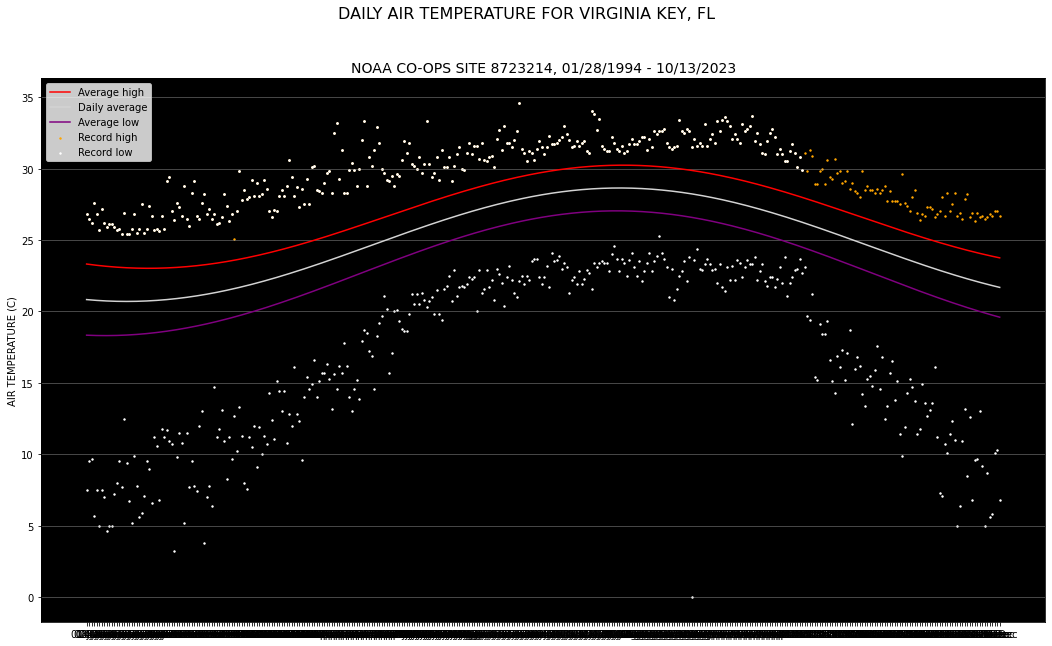

In [8]:
var = 'Air Temperature'
df = vk.get_stats_table()[var]
fig, ax = plt.subplots(1,1, figsize=(18,10))

plt.suptitle(f'Daily {var} for {vk.get_station()}'.upper(), fontsize=16)
plt.title('NOAA CO-OPS Site {}, {} - {}'.upper().format(
          vk.get_stationid(),
          vk.data.dropna(axis=0).index.min().strftime('%m/%d/%Y'),
          vk.data.dropna(axis=0).index.max().strftime('%m/%d/%Y')),
          fontsize=14)

ax.plot(cos_fit(df['Average High']), label='Average high', color='red')
ax.plot(cos_fit(df['Daily Average']), label='Daily average', color='lightgrey')
ax.plot(cos_fit(df['Average Low']), label='Average low', color='purple')

high_records = df.loc[df['Record High Year']==pd.to_datetime('today').year, 'Record High']
ax.scatter(df.index, df['Record High'], label='Record high', color='orange', s=2)
ax.scatter(high_records.index, high_records, color='white', s=3)
ax.scatter(df.index, df['Record Low'], label='Record low', color='white', s=2)

ax.set_facecolor('black')
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.5)
ax.set_ylabel(f'{var} ({vk.units[var]})'.upper())
# ax.set_ylim(58,97)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

In [10]:
var = 'Air Temperature'

In [11]:
# Color dictionary
# Mine from https://www.ipcc.ch/site/assets/uploads/2022/09/IPCC_AR6_WGI_VisualStyleGuide_2022.pdf
cols = dict({
    'Record High Year': 'black',
    'Record High': '#811b1e',
    'Average High': '#e71d25',
    'Monthly Average': 'grey',
    'Daily Average': 'grey',
    'Average Low': '#5292cd',
    'Record Low': '#0049cf'})
# McNoldy
# cols = dict({
#     'Record High Year': 'white',
#     'Record High': 'orange',
#     'Average High': 'red',
#     'Monthly Average': 'grey',
#     'Daily Average': 'grey',
#     'Average Low': 'purple',
#     'Record Low': 'white'})

In [12]:
def daily_climo(data, var, colors=cols, show=False):
    """Create a daily climatology plot for environmental variable 'var'
    from 'data'.
    
    Inputs:
        data: dict, climatological stats dictionary from Data class object
        var: str, one of the available environmental variables in 'data'
        colors: dict, dictionary of series:color defining color to use for
            each series (key) in 'data'
        show: Bool, whether to display plot (True) or return plot object
           (False, default) 
    """

    # Dates for x axis
    xdates = pd.date_range(start='2020-01-01',end='2020-12-31', freq='1D')
    df = data[var]
        
    # Create figure
    fig = go.Figure()

    # Add series
    annotations = []
    for key, color in colors.items():
        if 'Year' in key or 'Monthly' in key:
            continue
        if 'Average' in key:
            fig.add_trace(
            go.Scatter(
                x=xdates, y=cos_fit(df[key]).round(1),
                name=key.upper(),
                marker=dict(size=1, color=color)
            ))
            annotations.append(dict(x=0.95, y=cos_fit(df[key])[-1],
                               xref='paper', xshift=20,
                               xanchor='left', yanchor='middle',
                               text='{}'.format(key),
                               font=dict(family='Arial',
                                         size=14),
                               showarrow=False))
        else:
            fig.add_trace(
            go.Scatter(
                x=xdates, y=df[key],
                name=key.upper(),
                mode='markers',
                marker=dict(size=5, color=color)
            ))
            annotations.append(dict(x=0.95, y=df[key][-1],
                               xref='paper', xshift=20,
                               xanchor='left', yanchor='middle',
                               text='{}'.format(key),
                               font=dict(family='Arial',
                                         size=14),
                               showarrow=False))

    # High records this year
    high_records = df.loc[df['Record High Year']==pd.to_datetime('today').year, 'Record High']
    high_records.index = pd.to_datetime(high_records.index+'-2020')
    fig.add_trace(
    go.Scatter(
        x=high_records.index, y=high_records.values,
        name=f'{pd.to_datetime("today").year} Record'.upper(),
        mode='markers',
        marker=dict(size=7, color='black'),
        hoverinfo='none',
    ))

    # Low records this year
    low_records = df.loc[df['Record Low Year']==pd.to_datetime('today').year, 'Record Low']
    low_records.index = pd.to_datetime(low_records.index+'-2020')
    fig.add_trace(
    go.Scatter(
        x=low_records.index, y=low_records.values,
        name=f'{pd.to_datetime("today").year} Record'.upper(),
        mode='markers',
        marker=dict(size=7, color='black'),
        hoverinfo='none'
    ))

#     # Record highs
#     # High records this year
#     high_records = df.loc[df['Record High Year']==pd.to_datetime('today').year, 'Record High']
#     high_records.index = pd.to_datetime(high_records.index+'-2020')
#     fig.add_trace(
#     go.Scatter(
#         x=high_records.index, y=high_records.values,
#         name=f'{pd.to_datetime("today").year} Record'.upper(),
#         mode='markers',
#         marker=dict(size=6, color='white'),
#         hoverinfo='none'
#     ))
#     fig.add_trace(
#     go.Scatter(
#         x=xdates, y=df['Record High'],
#         name='Record High'.upper(),
#         mode='markers',
#         marker=dict(size=3, color='orange')
#     ))
#     # Average highs
#     fig.add_trace(
#     go.Scatter(
#         x=xdates, y=cos_fit(df['Average High']).round(1),
#         name='Average High'.upper(),
#         marker=dict(size=3, color='red')
#     ))
#     # Daily average
#     fig.add_trace(
#     go.Scatter(
#         x=xdates, y=cos_fit(df['Daily Average']).round(1),
#         name='Daily Average'.upper(),
#         marker=dict(size=3, color='grey')
#     ))
#     # Average lows
#     fig.add_trace(
#     go.Scatter(
#         x=xdates,
#         y=cos_fit(df['Average Low']).round(1),
#         name='Average Low'.upper(),
#         marker=dict(size=3, color='purple')
#     ))
#     # Record lows
#     fig.add_trace(
#     go.Scatter(
#         x=xdates, y=df['Record Low'],
#         name='Record Low'.upper(),
#         mode='markers',
#         marker=dict(size=3, color='white')
#     ))
    # Hover box
    fig.update_traces(
        # mode = 'markers',    
        hoverlabel = dict(bordercolor='white')
    )
    # Plot settings
    thisYear = dt.datetime.today().year
    fig.update_layout(
        template='plotly_white',
        # paper_bgcolor='rgba(0,0,0,0)',
        # plot_bgcolor='rgba(245,245,245,245)',
        plot_bgcolor='rgba(0,0,0,0)',
        # height=600, width=1000,
        title=dict(text='Daily {} Climatology since {}'.format(
                        var,
                        vk.filtered_data[var].dropna(axis=0).index.min().strftime('%B %Y')
                        # vk.filtered_data[var].dropna(axis=0).index.min().strftime('%m/%d/%Y'),
                        # vk.filtered_data[var].dropna(axis=0).index.max().strftime('%m/%d/%Y')
                        )+
                        '<br><sup>As of {}, <b>{}</b> daily records have been set in {}. Last year, {} daily records were set in total.</sup>'.format(
                        dt.datetime.today().strftime('%A, %b %d, %Y'),
                        (data[var]==thisYear).sum().sum(),
                        thisYear,
                        (data[var]==thisYear-1).sum().sum()),
                   font=dict(size=24,
                              # family='PT Sans Narrow'
                         )),
        yaxis = dict(title=f'{var} ({vk.units[var]})',
                     tickfont=dict(size=14),
                     titlefont=dict(size=14)),
        xaxis = dict(showgrid=False, showspikes=True,
                     dtick='M1', tickformat='%b %d',
                     tickfont=dict(size=14),
                     fixedrange=True),
        hovermode='x unified',
        legend=dict(itemsizing='constant'),
        hoverlabel=dict(font_size=12,
                        # font_family="Rockwell"
                       ),
        showlegend=False,
        annotations=annotations,
        margin=dict(r=22, l=0),
        dragmode=False
    )
    if show:
        fig.show()
    else:
        return fig

In [13]:
def monthly_climo(data, var, colors=cols, show=False):
    """Create a monthly climatology plot for environmental variable 'var'
    from 'data'.
    
    Inputs:
        data: dict, climatological stats dictionary from Data class object
        var: str, one of the available environmental variables in 'data'
        colors: dict, dictionary of series:color defining color to use for
            each series (key) in 'data'
        show: Bool, whether to display plot (True) or return plot object
           (False, default) 
    """

    # Dates for x axis
    xdates = pd.date_range(start='2020-01-01',end='2020-12-31', freq='MS')
    df = data[var]
    
    # Create figure
    fig = go.Figure()

    # Add series
    annotations = []
    for key, color in colors.items():
        if 'Year' in key or 'Daily' in key:
            continue
        if 'Average' in key:
            fig.add_trace(
            go.Scatter(
                x=xdates, y=cos_fit(df[key]).round(1),
                name=key.upper(),
                marker=dict(size=1, color=color)
            ))
            annotations.append(dict(x=0.93, y=cos_fit(df[key])[-1],
                               xref='paper', xshift=20,
                               xanchor='left', yanchor='middle',
                               text='{}'.format(key),
                               font=dict(family='Arial',
                                         size=14),
                               showarrow=False))
        else:
            fig.add_trace(
            go.Scatter(
                x=xdates, y=df[key],
                name=key.upper(),
                mode='markers',
                marker=dict(size=5, color=color)
            ))
            annotations.append(dict(x=0.93, y=df[key]['Dec'],
                               xref='paper', xshift=20,
                               xanchor='left', yanchor='middle',
                               text='{}'.format(key),
                               font=dict(family='Arial',
                                         size=14),
                               showarrow=False))

    # High records this year
    high_records = df.loc[df['Record High Year']==pd.to_datetime('today').year, 'Record High']
    high_records.index = pd.to_datetime(high_records.index+'-2020')
    fig.add_trace(
    go.Scatter(
        x=high_records.index, y=high_records.values,
        name=f'{pd.to_datetime("today").year} Record'.upper(),
        mode='markers',
        marker=dict(size=7, color='black'),
        hoverinfo='none',
    ))

    # Low records this year
    low_records = df.loc[df['Record Low Year']==pd.to_datetime('today').year, 'Record Low']
    low_records.index = pd.to_datetime(low_records.index+'-2020')
    fig.add_trace(
    go.Scatter(
        x=low_records.index, y=low_records.values,
        name=f'{pd.to_datetime("today").year} Record'.upper(),
        mode='markers',
        marker=dict(size=7, color='black'),
        hoverinfo='none'
    ))
        
    # Hover box
    fig.update_traces(
        # mode = 'markers',    
        hoverlabel = dict(bordercolor='white')
    )
    # Plot settings
    thisYear = dt.datetime.today().year
    fig.update_layout(
        template='plotly_white',
        # paper_bgcolor='rgba(245,245,245,245)',
        # plot_bgcolor='rgba(245,245,245,245)',
        plot_bgcolor='rgba(0,0,0,0)',
        #height=600, width=1000,
        title=dict(text='Monthly {} Climatology since {}'.format(
                        var,
                        vk.filtered_data[var].dropna(axis=0).index.min().strftime('%B %Y')
                        # vk.filtered_data[var].dropna(axis=0).index.min().strftime('%m/%d/%Y'),
                        # vk.filtered_data[var].dropna(axis=0).index.max().strftime('%m/%d/%Y')
                        )+
                        '<br><sup>As of {}, <b>{}</b> monthly records have been set in {}. Last year, {} monthly records were set in total.</sup>'.format(
                        dt.datetime.today().strftime('%A, %b %d, %Y'),
                        (data[var]==thisYear).sum().sum(),
                        thisYear,
                        (data[var]==thisYear-1).sum().sum()),
                   font=dict(size=24,
                              # family='PT Sans Narrow'
                         )),
        yaxis = dict(title=f'{var} ({vk.units[var]})',
                     tickfont=dict(size=14),
                     titlefont=dict(size=14)),
        xaxis = dict(showgrid=False, showspikes=True,
                     dtick='M1', tickformat='%b',
                     tickfont=dict(size=14),
                     fixedrange=True),
        hovermode='x unified',
        legend=dict(itemsizing='constant'),
        hoverlabel=dict(font_size=12,
                        # font_family="Rockwell"
                       ),
        showlegend=False,
        annotations=annotations,
        margin=dict(r=22, l=0),
        dragmode=False
    )
    fig.update_yaxes(ticksuffix = "  ")
    if show:
        fig.show()
    else:
        return fig

In [14]:
#daily_climo(vk.get_daily_stats_table(), 'Air Temperature')

In [15]:
monfig = monthly_climo(vk.get_monthly_stats_table(), 'Air Temperature', show=False)

In [16]:
plotly.io.write_html(monfig, file=os.path.join(os.getcwd(), '_includes', 'figure-virginiakeyfl-airtemperature-monthly.html'),
                     auto_open=True, full_html=False, include_plotlyjs='cdn',
                     config=dict(responsive=True,
                                 scrollZoom=True,
                                 displaylogo=False,
                                 modeBarButtonsToRemove=['lasso', 'select']))

In [17]:
dayfig = daily_climo(vk.get_daily_stats_table(), 'Air Temperature', show=False)

In [18]:
plotly.io.write_html(dayfig, file=os.path.join(os.getcwd(), '_includes', 'figure-virginiakeyfl-airtemperature-daily.html'),
                     auto_open=True, full_html=False, include_plotlyjs='cdn',
                     config=dict(responsive=True,
                                 scrollZoom=True,
                                 displaylogo=False,
                                 modeBarButtonsToRemove=['lasso', 'select']))

In [879]:
vk.get_monthly_stats_table('Air Temperature')

,Monthly Average,Record High Monthly Average,Record High Monthly Average Year,Record Low Monthly Average,Record Low Monthly Average Year,Average High,Lowest High,Lowest High Year,Record High,Record High Year,Average Low,Highest Low,Highest Low Year,Record Low,Record Low Year,Number of Years
Jan,68.7,72.6,2013,63.0,2001,76.1,73.0,2011,78.7,2016,55.3,63.5,2013,48.3,1997,26
Feb,70.7,74.9,2018,62.7,2010,76.4,73.8,2010,78.6,2021,59.3,71.8,2003,47.9,1996,27
Mar,72.2,77.6,2003,66.1,2010,78.4,74.2,2010,82.8,2003,63.4,72.0,1997,55.1,1996,27
Apr,75.5,79.5,2002,71.4,2005,80.5,75.9,2005,85.8,2020,68.3,77.1,2002,61.2,2009,28
May,78.4,80.7,1995,74.8,2001,82.1,79.4,2007,85.2,1995,73.7,77.1,2003,67.9,1999,28
Jun,81.2,83.6,2010,78.7,2002,84.4,82.0,2002,87.6,2009,77.4,80.8,2004,74.6,2007,27
Jul,82.9,85.0,2023,81.0,2013,85.7,84.2,2012,88.7,2018,79.1,82.3,2022,76.1,2013,27
Aug,83.2,85.9,2022,81.8,1994,85.6,84.0,2003,88.5,2022,79.4,83.6,2022,76.1,1996,28
Sep,82.2,86.4,2022,80.6,2001,85.2,82.8,1997,89.4,2022,78.5,83.8,2022,74.3,2001,28
Oct,79.7,82.6,2023,77.5,2000,83.6,81.0,2010,86.8,2023,73.2,80.2,2023,64.6,2005,26


In [908]:
var = 'Water Temperature'

In [909]:
g = vk.filtered_data['Water Temperature'].groupby(pd.Grouper(freq='M')).mean(numeric_only=True)

In [915]:
g[g.isna()['Water Temperature']]

(43, 5)

In [911]:
vk.filtered_data[var].loc['2019-12-31']

,Water Temperature,Year,Month,Day,YearDay,DOY
time_lst,,,,,,


In [912]:
g2 = vk.data['Water Temperature'].groupby(pd.Grouper(freq='M')).mean(numeric_only=True)

In [913]:
g2

time_lst
1994-01-31    74.200000
1994-02-28    74.359346
1994-03-31    75.420326
1994-04-30    79.387291
1994-05-31    82.640816
                ...    
2023-06-30    85.444775
2023-07-31    89.422191
2023-08-31    88.533938
2023-09-30    86.722042
2023-10-31    85.322129
Freq: M, Name: Water Temperature, Length: 358, dtype: float64

In [917]:
g2[g2.isna()]

time_lst
2006-10-31   NaN
2006-11-30   NaN
2006-12-31   NaN
2007-02-28   NaN
2007-03-31   NaN
2007-04-30   NaN
2007-05-31   NaN
2007-06-30   NaN
2007-07-31   NaN
2007-08-31   NaN
2007-09-30   NaN
2007-10-31   NaN
2007-11-30   NaN
2007-12-31   NaN
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
2008-06-30   NaN
2008-07-31   NaN
2008-08-31   NaN
2008-09-30   NaN
2008-10-31   NaN
2008-11-30   NaN
2008-12-31   NaN
2009-01-31   NaN
2009-02-28   NaN
2017-03-31   NaN
2019-03-31   NaN
2019-04-30   NaN
2019-05-31   NaN
2019-06-30   NaN
2019-07-31   NaN
2019-08-31   NaN
2019-09-30   NaN
2019-10-31   NaN
2019-11-30   NaN
Name: Water Temperature, dtype: float64